# LDA Classification
This script runs LDA to look at individual differences

---
# Contents
---
- [Table of Contents](#Contents)
- [LDA](#Running-the-LDA)
- [Visualization](#Visualization)
    - [Strongest cue](#Strongest-cue)
    - [Cues and social factors](#Cues-and-social-factors)
    - [Cue tradeoff](#Cue-tradeoff)
    - [f0 importance vs. VQ cues](#f0-importance-vs.-VQ-cues)
    - [Age and TLE](#Age-and-TLE)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5, style = 'whitegrid')
sns.plotting_context(rc={"grid.linewidth": 0.5})

# For LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA

from progressbar import ProgressBar
from datetime import datetime

# For correlations
from scipy.stats import pearsonr

### Functions

In [2]:
def dist_to_line(a, b, c, x, y):
    '''
    Line defined by ax + by + c = 0, where a is the slope
    x and y define the point we want to calculate distance from.
    Positive tells us it is to the right of the origin
    '''
    num = ((a * x) + (b * y) + c)
    den = ((a**2 + b**2))**(1/2)
    
    return(num/den)

def regplot_hue(data, x, y, hue, palette = 'coolwarm', col = False, col_order = False,
                xlim = None, ylim = None, line = True, line_cols = [], line_color = 'black', 
                s = 70, height = 5, aspect = 1, **kwargs):
    
    '''
    This function creates a plot and adds a regression line while allowing the continuous hue to exist.
    Usually, relplot allows continuous hue but doesn't allow a regression line.
    On the other hand, lmplot doesn't allow a continuous hue
    
    data: dataframe we are working with
    x, y: x and y variables
    hue: which variable to use as the hue
    col: what variable we should facet by
    col_order: order of facets
    palette: color scheme you want to use
    
    xlim, ylim: leave blank if you don't want to limit it, otherwise give tuple for the range
    line: True if you want the regression line, False if you don't
    line_cols: which columns the line should be drawn on
    line_color: color of the regression line
    s: size of the points
    '''
    
    if col != False:
        g = sns.relplot(data = data, x = x, y = y, hue = hue, col = col, col_order = col_order, palette = palette, 
                        s = s, height = height, aspect = aspect, **kwargs)
    
    else:
        g = sns.relplot(data = data, x = x, y = y, hue = hue, palette = palette, s = s, 
                        height = height, aspect  = aspect, **kwargs)
    
    if xlim != None:
        g.set(xlim = xlim)
    if ylim != None:
        g.set(ylim = ylim)
    
    if line == True:
        if col != False:
            for i in line_cols:
                sns.regplot(x=x, y=y, data=data[data[col] == col_order[i]], scatter=False, ax=g.axes[0, i], line_kws={"color": line_color}, **kwargs)
        
        else:
            sns.regplot(x=x, y=y, data=data, scatter=False, line_kws={"color": line_color}, **kwargs)
       
    return(g)

## Read in data

In [3]:
# Read in scaled values and demographic data
prod_full = pd.read_csv('../0_data/kuy-production-clean.csv') 
prod_dem = pd.read_csv('../0_data/kuy-production-dem.csv')

# Rename columns in production data to be simpler
factors = ['f0_semitones', 'H1H2c', 'H1Anc_PC', 'CPP', 'F1_semitones']

factors = [f + '_scaled' for f in factors]

factors_short = ['f0', 'H1H2c', 'H1Anc', 'CPP', 'F1']

renamecolumns = {factors[i]:factors_short[i] for i in range(len(factors))}

# Select columns we want and rename
prod_df = prod_full[['sp','word','round','order','time','Label','duration', 'vowelqual','register']+factors].dropna()
prod_df = prod_df.rename(columns=renamecolumns)

In [4]:
# The production factors we want to look at
prod_pitch_factors = ['f0']
prod_vq_factors = ['H1H2c','H1Anc','CPP']
prod_vowelq_factors = ['F1']

prod_factors = prod_pitch_factors + prod_vq_factors + prod_vowelq_factors

# Social factors
prod_social = ['TLE', 'away']

# Names
prod_factor_names = dict(zip(prod_factors + ['VQ'], ['f0', 'H1* - H2*', 'H1* (- An*)', 'CPP', 'F1', 'VQ']))
prod_soc_names = {'TLE': 'Tonal Language Experience', 'away':'Time Away'}

---
# Running the LDA
---
Define a function to return the accuracy of a trained LDA on a set of data.  This function takes in some data (x) and labels (y), trains an LDA on that data, then tests its accuracy using the same data, and returns the proportion of correctly labelled data points.

The idea here is that, all else being equal, if a speaker's breathy/modal contrast manifests wholly in voice quality measures (and not at all in pitch), a classifer trained on only voice quality measures will perform at or near 100% while a classifier trained on only f0 will perform at or near 50%.

- [Table of Contents](#Contents)
- [LDA](#Running-the-LDA)
- [Visualization](#Visualization)
    - [Strongest cue](#Strongest-cue)
    - [Cues and social factors](#Cues-and-social-factors)
    - [Cue tradeoff](#Cue-tradeoff)
    - [f0 importance vs. VQ cues](#f0-importance-vs.-VQ-cues)
    - [Age and TLE](#Age-and-TLE)

### A function to get the LDA standardized coefficients

In [5]:
def add_dlist(d, k, v):
    '''Initialize dictionary key with list if doesn't exist'''
    if k not in d:
        d[k] = []
    d[k].append(v)

def lda_acc(data, predictors, labels, folds = 10, seeds = [0]):
    '''
    Return both the standardized coefficients and the accuracies if there is more than one predictor
    - data: the dataframe we are working with
    - predictors: list of predictors (i.e. f0 value)
    - labels: list of labels (i.e. modal vs. breathy)
    - folds: how many folds we want to cross-validate with
    - seeds: numbers for the random states to test with (for replicability)
    '''
    
    # Dictionary for full results
    lda_full_res = {}
    
    for i in seeds:
    
        # Initialize dictionary to store results
        lda_res = {}

        # K-folds
        kf = KFold(n_splits = folds, random_state = i, shuffle = True)

        X = data[predictors]
        y = data[labels]

        for train_index, test_index in kf.split(X):
        
            # Split into training and test set
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Initialize the LDA
            lda = LDA()

            # Fit and transform the training sets
            X_train = lda.fit_transform(X_train, y_train)

            # Transform the predictors test set
            X_test = lda.transform(X_test)

            # Initialize the classifier and fit the classifier to the training sets
            classifier = LogisticRegression(max_iter = 100000)
            classifier.fit(X_train, y_train)

            # Predict categories based on the predictor test set 
            y_pred = classifier.predict(X_test)

            # Compare the results of prediction to the categories test set
            add_dlist(lda_res, 'acc', accuracy_score(y_test, y_pred))

        # Get means of each
        for k, v in lda_res.items():
            add_dlist(lda_full_res, k, sum(v)/len(v))
    
    # Now mean the means
    for k, v in lda_full_res.items():
         lda_full_res[k] = sum(v)/len(v)
    
    return(lda_full_res)

### Set seeds and folds

In [6]:
# Seeds to rerun LDA with
# k-folds
seeds = range(0,10)
folds = 10

## Run LDA

In [7]:
# Create accuracy DF
acc_prod_df = pd.DataFrame(columns=['sp'] + ['acc_' + fac for fac in prod_factors] + ['acc_VQ', 'acc_all'])

# For each speaker
start = datetime.now()

for s in ProgressBar()(prod_df['sp'].unique()):
    
    sp_df = prod_df[prod_df.sp == s]

    # Dictionary to store measures
    accs = {}

    # Get accuracy for each measure
    for fac in prod_factors:
        
        accs['acc_' + fac] = lda_acc(sp_df, [fac], 'register', folds = folds, seeds = seeds)['acc']
    
    # VQ accuracy
    VQ_dict = lda_acc(sp_df, prod_vq_factors, 'register', folds = folds, seeds = seeds)
    
    # All accuracy and coefficients
    all_dict = lda_acc(sp_df, prod_factors, 'register', folds = folds, seeds = seeds)
    
    # Put together accuracy dataframe
    acc_prod_df = pd.concat([acc_prod_df,
                       pd.DataFrame([[s] + [accs['acc_' + fac] for fac in prod_factors] + 
                                     [VQ_dict['acc'], all_dict['acc']]], 
                                     columns = acc_prod_df.columns)],
                       axis = 0)

print('Time taken to run LDA:', datetime.now() - start)

Time taken to run LDA: 0:07:25.057875


## Save to file

In [8]:
lda_prod_df = prod_dem[['sp', 'age', 'gender', 'TLE', 'away']].merge(acc_prod_df, on = 'sp')

lda_prod_df.to_csv('../0_data/kuy-production-lda.csv', index = False)

lda_prod_df.head()

,sp,age,gender,TLE,away,acc_f0,acc_H1H2c,acc_H1Anc,acc_CPP,acc_F1,acc_VQ,acc_all
0,1,31,f,0.299874,0.262578,0.673788,0.494463,0.509831,0.535226,0.612162,0.566914,0.740565
1,2,34,m,0.225491,-0.599356,0.702691,0.775317,0.749544,0.601315,0.678659,0.862859,0.867247
2,3,50,m,-0.035023,-0.599356,0.700187,0.592914,0.580792,0.570616,0.673978,0.745093,0.742211
3,4,27,m,0.029542,-0.035088,0.599203,0.801572,0.608381,0.507552,0.612465,0.810459,0.813873
4,5,22,f,0.622980,-0.599356,0.658244,0.571128,0.596343,0.606161,0.729713,0.705937,0.827885


## Read in file
Start here if you have already run the LDA and have a saved file

In [9]:
lda_prod_df = pd.read_csv('../0_data/kuy-production-lda.csv')

lda_prod_df.head()

,sp,age,gender,TLE,away,acc_f0,acc_H1H2c,acc_H1Anc,acc_CPP,acc_F1,acc_VQ,acc_all
0,1,31,f,0.299874,0.262578,0.673788,0.494463,0.509831,0.535226,0.612162,0.566914,0.740565
1,2,34,m,0.225491,-0.599356,0.702691,0.775317,0.749544,0.601315,0.678659,0.862859,0.867247
2,3,50,m,-0.035023,-0.599356,0.700187,0.592914,0.580792,0.570616,0.673978,0.745093,0.742211
3,4,27,m,0.029542,-0.035088,0.599203,0.801572,0.608381,0.507552,0.612465,0.810459,0.813873
4,5,22,f,0.622980,-0.599356,0.658244,0.571128,0.596343,0.606161,0.729713,0.705937,0.827885


---
# Visualization
---
## Strongest cue
See what the strongest cue is for each speaker

- [Table of Contents](#Contents)
- [LDA](#Running-the-LDA)
- [Visualization](#Visualization)
    - [Cues and social factors](#Cues-and-social-factors)
    - [Cue tradeoff](#Cue-tradeoff)
    - [f0 importance vs. VQ cues](#f0-importance-vs.-VQ-cues)
    - [Age and TLE](#Age-and-TLE)

In [10]:
# Compare with VQ?
#  If True, VQ accuracy will be compared with all the individual measures
vq_compare = True

# Turn to long data set
lda_prod_long = pd.melt(lda_prod_df[['sp', 'gender', 'age', 'TLE', 'away'] + 
                                    ['acc_' + m for m in prod_factors + ['VQ', 'all']]], 
                        id_vars = ['sp', 'gender', 'age', 'TLE', 'away', 'acc_all'], 
                        var_name = 'measure', value_name = 'acc')

# Dictionary with names for acc
new_names_d = {}

for k, v in prod_factor_names.items():
    new_names_d['acc_' + k] = v

# Get rows with max
lda_max = lda_prod_long.query('measure != "acc_VQ"') if vq_compare == False else lda_prod_long

idx = lda_max.groupby('sp')['acc'].transform(max) == lda_max['acc']
max_meas = lda_max[idx].reset_index()

# Categorize TLE into top and bottom half
max_meas['TLE_half'] = max_meas['TLE'].apply(lambda x: 'less' if x < 0 else 'more')

# Count how many of each cue is most important
print(max_meas.groupby(['gender']).measure.value_counts())
print(max_meas.groupby(['gender', 'TLE_half']).measure.value_counts())

gender  measure  
f       acc_VQ       17
        acc_f0       10
        acc_F1        7
m       acc_VQ       22
        acc_F1        5
        acc_f0        3
        acc_H1H2c     2
Name: measure, dtype: int64
gender  TLE_half  measure  
f       less      acc_VQ       10
                  acc_F1        4
                  acc_f0        2
        more      acc_f0        8
                  acc_VQ        7
                  acc_F1        3
m       less      acc_VQ        9
                  acc_F1        5
                  acc_H1H2c     1
                  acc_f0        1
        more      acc_VQ       13
                  acc_f0        2
                  acc_H1H2c     1
Name: measure, dtype: int64


---
## Cues and social factors
---
Compare the accuracy of each measure to the social factors

- [Table of Contents](#Contents)
- [LDA](#Running-the-LDA)
- [Visualization](#Visualization)
    - [Strongest cue](#Strongest-cue)
    - [Cue tradeoff](#Cue-tradeoff)
    - [f0 importance vs. VQ cues](#f0-importance-vs.-VQ-cues)
    - [Age and TLE](#Age-and-TLE)

Correlation between: f0 & TLE (f): (0.5249460994973119, 0.001435057907171616)
Correlation between: f0 & TLE (m): (0.037640272412901174, 0.8379421964460793)



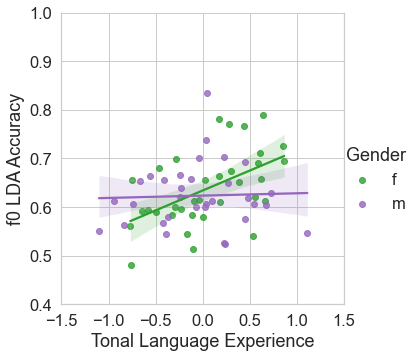

Correlation between: H1H2c & TLE (f): (-0.35279350983585867, 0.04070665977720209)
Correlation between: H1H2c & TLE (m): (0.49973374634635137, 0.0035891350587584987)



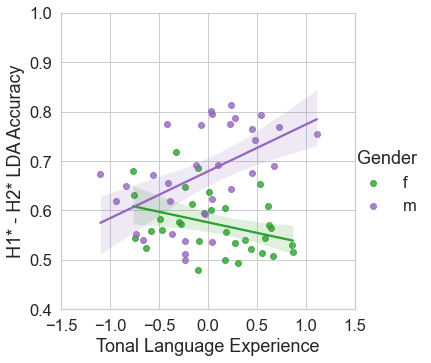

Correlation between: H1Anc & TLE (f): (-0.341670425153214, 0.0479607593020115)
Correlation between: H1Anc & TLE (m): (0.048876707449782966, 0.7905112878529297)



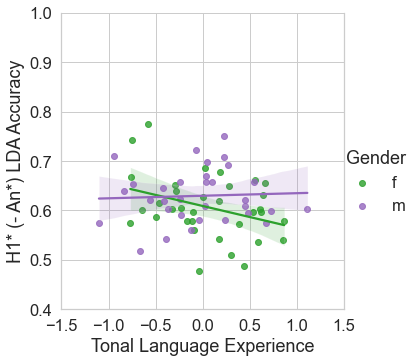

Correlation between: CPP & TLE (f): (0.40425365129828894, 0.01772916776289483)
Correlation between: CPP & TLE (m): (0.13990248051999105, 0.4450528802535034)



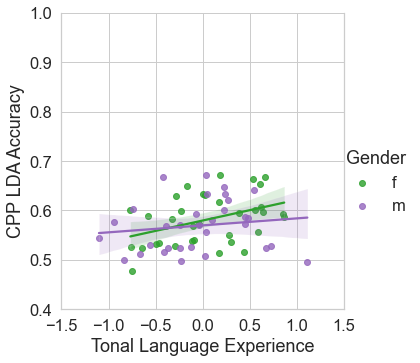

Correlation between: F1 & TLE (f): (0.28031920997428433, 0.10832405973140556)
Correlation between: F1 & TLE (m): (-0.37972555146554887, 0.03206397129951261)



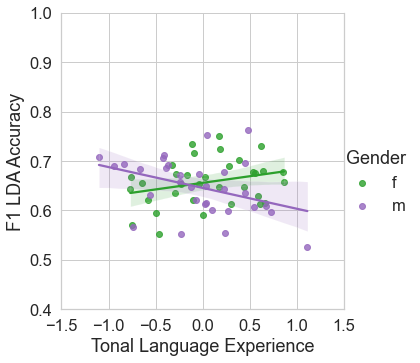

Correlation between: VQ & TLE (f): (-0.2611666066660735, 0.13572002659725077)
Correlation between: VQ & TLE (m): (0.44874023781995653, 0.009992284693076448)



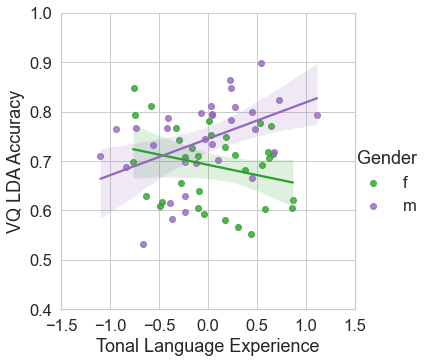

Correlation between: f0 & away (f): (0.15734298244972042, 0.3741664301451401)
Correlation between: f0 & away (m): (0.07428824071877163, 0.686155832885481)



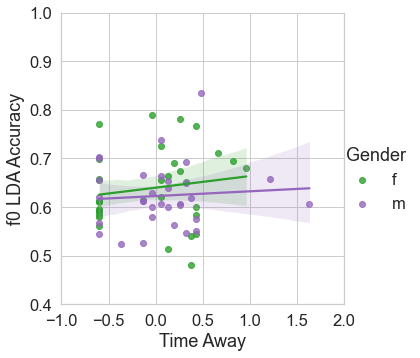

Correlation between: H1H2c & away (f): (-0.16092678268614397, 0.3632427443048192)
Correlation between: H1H2c & away (m): (0.041017214632046314, 0.8236206933095137)



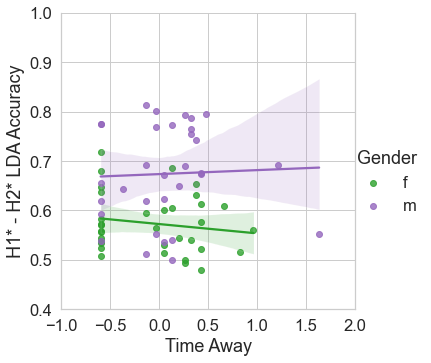

Correlation between: H1Anc & away (f): (-0.3207180462834669, 0.06440949381709783)
Correlation between: H1Anc & away (m): (-0.06477207858621632, 0.7246893366023487)



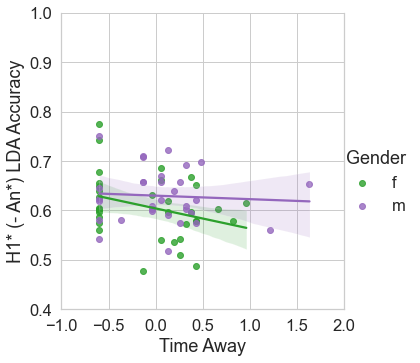

Correlation between: CPP & away (f): (-0.10093963590361082, 0.5700261632350079)
Correlation between: CPP & away (m): (-0.07551413556766175, 0.6812453055864578)



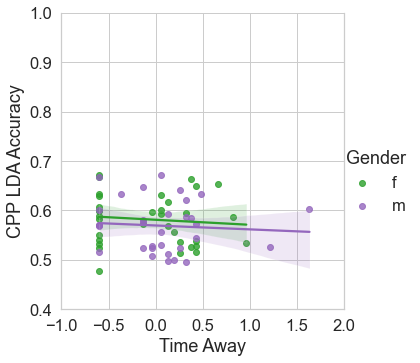

Correlation between: F1 & away (f): (-0.0892893668181582, 0.615545996337691)
Correlation between: F1 & away (m): (-0.2149694376889293, 0.23738640007100187)



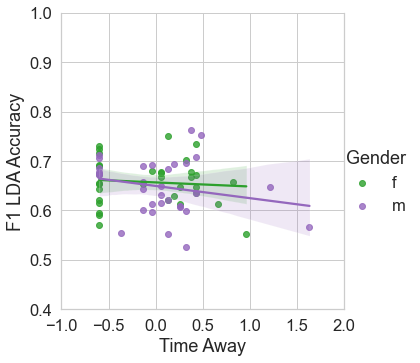

Correlation between: VQ & away (f): (-0.25394164453640883, 0.1472774372338191)
Correlation between: VQ & away (m): (0.018489840141918727, 0.9199939395592932)



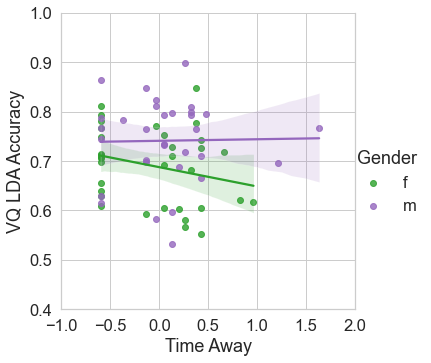

In [11]:
for soc in prod_social:

    for fac in prod_factors + ['VQ']:
        
        g = sns.lmplot(data = lda_prod_df, x = soc, y = 'acc_' + fac, hue = 'gender', 
                       palette =  [sns.color_palette('tab10')[i] for i in [2,4]])

        g.axes.flat[0].set(xlabel = prod_soc_names[soc], ylabel = prod_factor_names[fac] + ' LDA Accuracy',
                           ylim = (0.4, 1), 
                           xlim = (-1.5, 1.5) if soc == 'TLE' else (-1, 2),
                           xticks = np.arange(-1.5, 2, .5) if soc == 'TLE' else np.arange(-1, 2.5, 0.5))
        
        g._legend.set_title('Gender')

        g.despine(right = False)
        
        g.savefig('-'.join([fac, soc]) + '.png', dpi = 300, bbox_inches = 'tight')

        # Stats
        print('Correlation between:', fac, '&', soc, '(f):', pearsonr(lda_prod_df.query('gender == "f"')[soc], lda_prod_df.query('gender == "f"')['acc_' + fac]))
        print('Correlation between:', fac, '&', soc, '(m):', pearsonr(lda_prod_df.query('gender == "m"')[soc], lda_prod_df.query('gender == "m"')['acc_' + fac]))
        print()
        
        plt.show()

---
## Cue tradeoff
---
Compare f0 to each factor to see if there is tradeoff

- [Table of Contents](#Contents)
- [LDA](#Running-the-LDA)
- [Visualization](#Visualization)
    - [Strongest cue](#Strongest-cue)
    - [Cues and social factors](#Cues-and-social-factors)
    - [f0 importance vs. VQ cues](#f0-importance-vs.-VQ-cues)
    - [Age and TLE](#Age-and-TLE)

In [12]:
for fac1 in prod_factors + ['VQ']:
    
    for fac2 in [f for f in prod_factors + ['VQ'] if f != fac1]:

        print('Correlation between:', fac1, '&', fac2, '(f):', pearsonr(lda_prod_df.query('gender == "f"')['acc_' + fac1], lda_prod_df.query('gender == "f"')['acc_' + fac2]))
        print('Correlation between:', fac1, '&', fac2, '(m):', pearsonr(lda_prod_df.query('gender == "m"')['acc_' + fac1], lda_prod_df.query('gender == "m"')['acc_' + fac2]))
        print()

Correlation between: f0 & H1H2c (f): (-0.5358893820933391, 0.0010891218851809608)
Correlation between: f0 & H1H2c (m): (-0.0427824324807175, 0.8161562843907831)

Correlation between: f0 & H1Anc (f): (-0.21167636489426775, 0.2294473173745932)
Correlation between: f0 & H1Anc (m): (0.23999869671812052, 0.18581647276749583)

Correlation between: f0 & CPP (f): (-0.1460243272497377, 0.4099150130819021)
Correlation between: f0 & CPP (m): (0.1378671930320239, 0.45176843074919054)

Correlation between: f0 & F1 (f): (0.01948215990358472, 0.9129164510515938)
Correlation between: f0 & F1 (m): (0.2917018105198126, 0.10525039807450207)

Correlation between: f0 & VQ (f): (-0.42531264883079134, 0.012156546287036333)
Correlation between: f0 & VQ (m): (0.08804519939141767, 0.6318137608128063)

Correlation between: H1H2c & f0 (f): (-0.5358893820933391, 0.0010891218851809608)
Correlation between: H1H2c & f0 (m): (-0.0427824324807175, 0.8161562843907831)

Correlation between: H1H2c & H1Anc (f): (0.09772578

### Visualize relationship between f0 and each cue

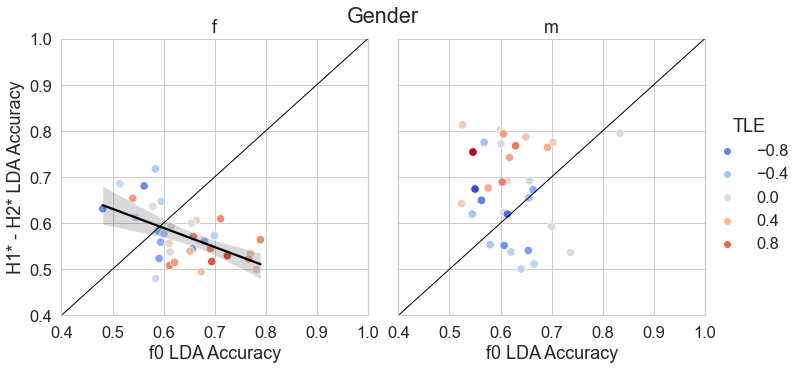

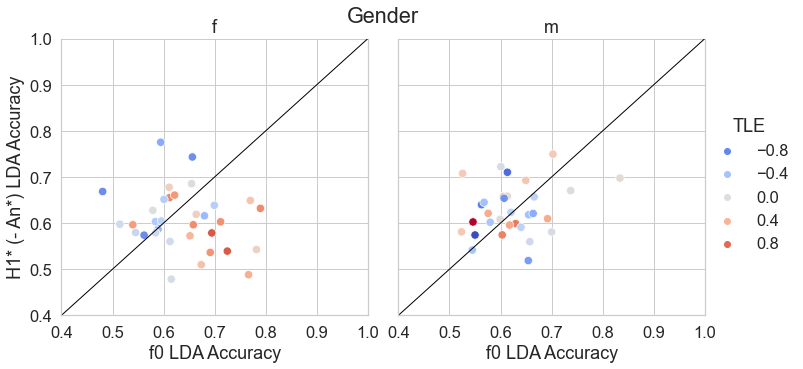

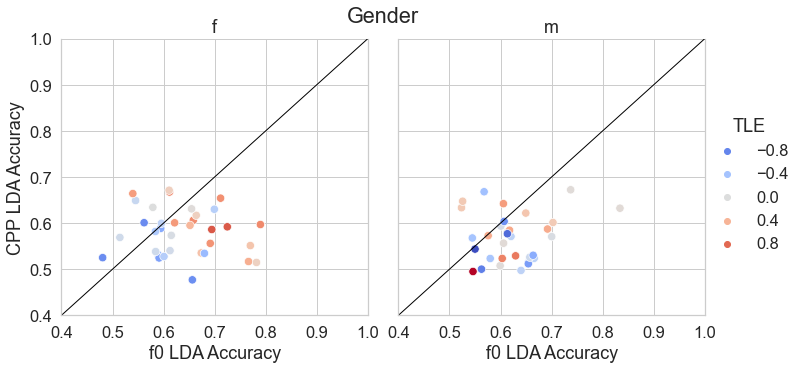

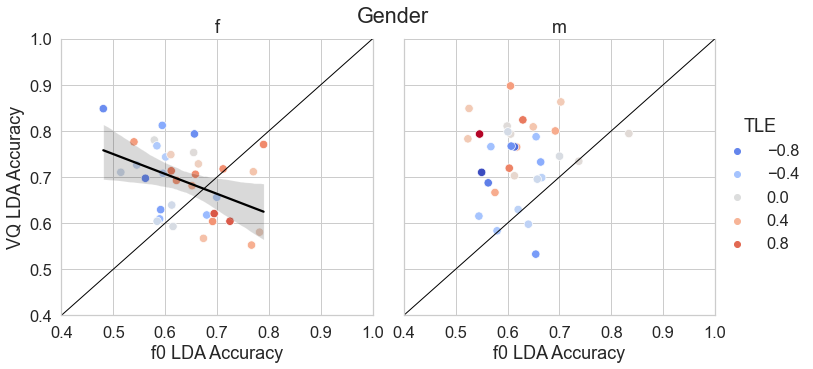

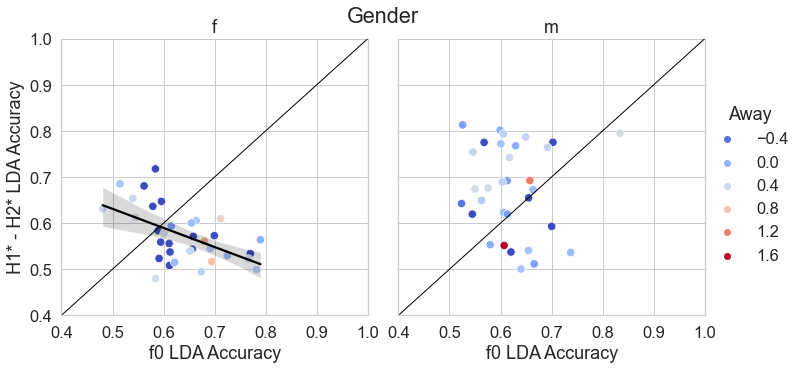

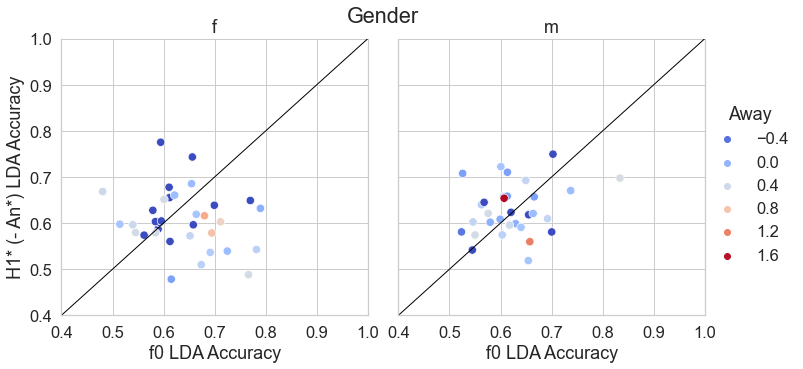

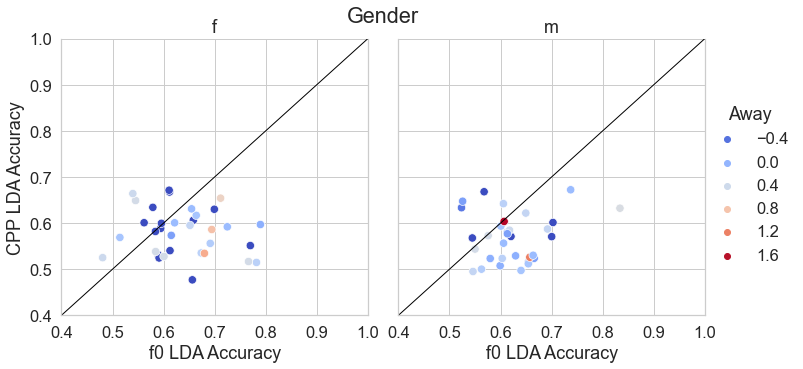

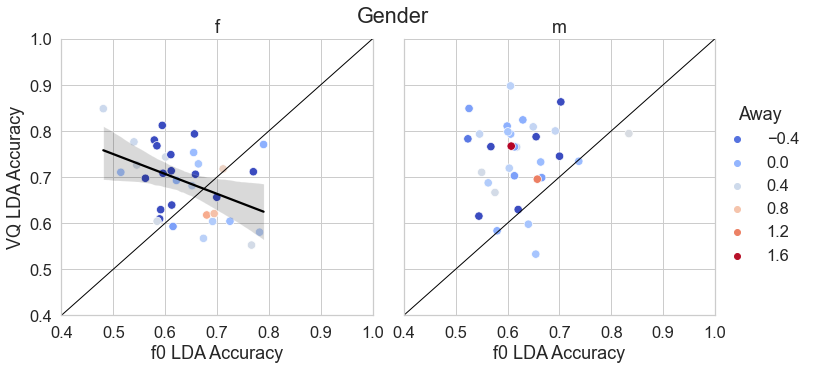

In [13]:
genders = ['f', 'm']

for soc in prod_social:

    for fac in prod_vq_factors + ['VQ']:

        line = True if (fac in ['H1H2c', 'VQ']) else False

        g = regplot_hue(data = lda_prod_df, x = 'acc_f0', y = 'acc_' + fac, hue = soc, palette = 'coolwarm',
                        col = 'gender', col_order = genders, line = line, line_cols = [0], line_color = 'black', 
                        xlim = (0.4, 1), ylim = (0.4, 1), height = 5, aspect = 1)

        g.axes[0][0].set_ylabel(prod_factor_names[fac] + ' LDA Accuracy')

        for ax, gen in zip(g.axes[0], genders):
            ax.plot([0, 1], [0, 1], linewidth=1, color = 'black')
            ax.set_xlabel('f0 LDA Accuracy')
            ax.set_title(gen)

        g.fig.suptitle('Gender', x = 0.48)

        if soc == 'away': g._legend.set_title(soc.capitalize())

        g.despine(left = False, bottom = False, right = False)

        plt.subplots_adjust(hspace=0, wspace=0.1)

        g.savefig('-'.join(['corr', 'f0', fac, soc]) + '.png', dpi = 300, bbox_inches = 'tight')

---
## Age and TLE
---
While age and TLE are hard to tease apart, let's see if there are any patterns

- [Table of Contents](#Contents)
- [LDA](#Running-the-LDA)
- [Visualization](#Visualization)
    - [Strongest cue](#Strongest-cue)
    - [Cues and social factors](#Cues-and-social-factors)
    - [Cue tradeoff](#Cue-tradeoff)
    - [f0 importance vs. VQ cues](#f0-importance-vs.-VQ-cues)

Correlation between age and f0 accuracy (-0.5870556707379417, 0.0002626184891077225)


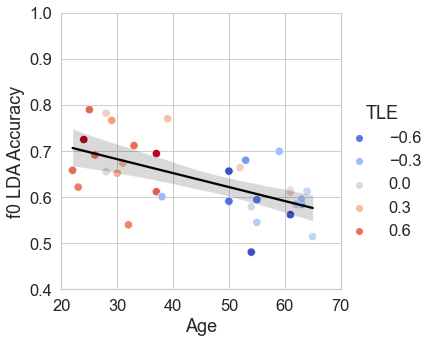

In [14]:
g = regplot_hue(data = lda_prod_df.query('gender == "f"'), x = 'age', y = 'acc_f0', 
                    hue = 'TLE', palette = 'coolwarm',
                    col = 'gender', col_order = ['f'], line = True, line_cols = [0])

for ax in g.axes.flat:
    ax.set(xlabel = 'Age', xlim = (20,70))

g.axes.flat[0].set(ylabel = 'f0 LDA Accuracy', ylim = (0.4, 1), title = '')

g.despine(left = False, bottom = False, right = False)

print('Correlation between age and f0 accuracy', pearsonr(lda_prod_df.query('gender == "f"')['age'], lda_prod_df.query('gender == "f"')['acc_f0']))

plt.savefig('age-tle-f.png', dpi = 300, bbox_inches = 'tight')